In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

from keras.utils import np_utils

import os

In [12]:
# get current working directory
CWD = os.getcwd()

# path url to dataset
DATASET_PATH = CWD + "\Dataset\\fer2013.csv"
print(DATASET_PATH)

C:\Users\Mark\Downloads\drive-download-20220523T092121Z-001\Thesis Model Training\Dataset\fer2013.csv


In [15]:
data = pd.read_csv(DATASET_PATH)
print(data.shape)
#preview first 5 row of data
data.head(5)

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label = {
    0:'anger', 
    1:'disgust', 
    2:'fear', 
    3:'happiness', 
    4: 'sadness', 
    5: 'surprise', 
    6: 'neutral'
}

In [ ]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
x_data = data['pixels']
y_data = data['emotion']
print(x_data.shape, y_data.shape)

(35887,) (35887,)


In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [ ]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    22 22 23 33 24 24 23 23 25 29 32 27 33 40 50 8...
62919    72 71 68 76 72 76 77 81 88 89 93 97 95 92 90 8...
62920    119 116 171 225 209 206 217 143 94 167 168 115...
62921    48 53 47 91 137 116 77 135 147 121 132 137 134...
62922    102 100 98 90 90 102 96 103 75 85 80 87 98 101...
Length: 62923, dtype: object

In [ ]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [ ]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [ ]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.1,
                                                    shuffle=True, 
                                                    random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [ ]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [ ]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [ ]:
chk_path = 'best_model.h5'
checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss'
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [
    early_stopping,
    checkpoint,
    lr_scheduler
]

In [ ]:
def get_model():
  model = Sequential([
      Input((48, 48, 1)),

      Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
      BatchNormalization(axis=3),
      Activation('relu'),
      Dropout(0.2),

      Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
      BatchNormalization(axis=3),
      Activation('relu'),
      Dropout(0.2),

      MaxPooling2D((2,2)),

      Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
      BatchNormalization(axis=3),
      Activation('relu'),
      Dropout(0.2),
      
      Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
      BatchNormalization(axis=3),
      Activation('relu'),
      Dropout(0.2),

      MaxPooling2D((2,2)),

      Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
      BatchNormalization(axis=3),
      Activation('relu'),
      Dropout(0.2),
      
      MaxPooling2D((2,2)),

      Flatten(),
      Dense(200, activation='relu'),
      Dropout(0.5),
      Dense(7, activation = 'softmax')
  ])
  adam = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
model = get_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                        

In [ ]:
# x_train.shape, x_test.shape, y_train.shape, y_test.shape
model_history = model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
1770/1770 [==============================] - ETA: 0s - loss: 1.8671 - accuracy: 0.2483
Epoch 1: val_loss improved from inf to 1.80706, saving model to second_model.h5
1770/1770 [==============================] - 70s 33ms/step - loss: 1.8671 - accuracy: 0.2483 - val_loss: 1.8071 - val_accuracy: 0.2720 - lr: 1.0000e-04
Epoch 2/100
1769/1770 [============================>.] - ETA: 0s - loss: 1.6338 - accuracy: 0.3644
Epoch 2: val_loss improved from 1.80706 to 1.55588, saving model to second_model.h5
1770/1770 [==============================] - 58s 33ms/step - loss: 1.6337 - accuracy: 0.3644 - val_loss: 1.5559 - val_accuracy: 0.4200 - lr: 1.0000e-04
Epoch 3/100
1769/1770 [============================>.] - ETA: 0s - loss: 1.4723 - accuracy: 0.4353
Epoch 3: val_loss improved from 1.55588 to 1.43908, saving model to second_model.h5
1770/1770 [==============================] - 57s 32ms/step - loss: 1.4723 - accuracy: 0.4353 - val_loss: 1.4391 - val_accuracy: 0.4507 - lr: 1.0000e-04

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

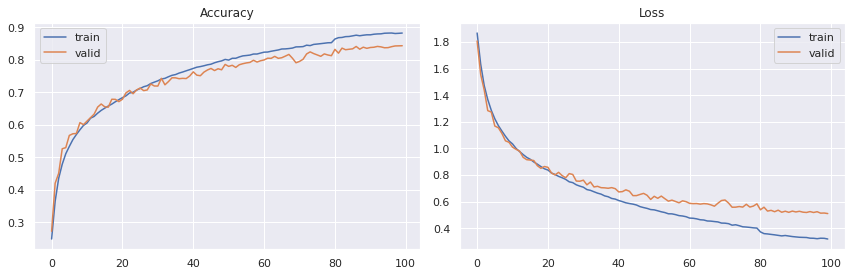

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(model_history.epoch, model_history.history['accuracy'], label='train')
sns.lineplot(model_history.epoch, model_history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(model_history.epoch, model_history.history['loss'], label='train')
sns.lineplot(model_history.epoch, model_history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# plt.savefig('model_with_augmentation_history.png')
plt.show()

In [ ]:
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(x_test), axis=1)
print("CNN Model Accuracy: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy: 0.8435


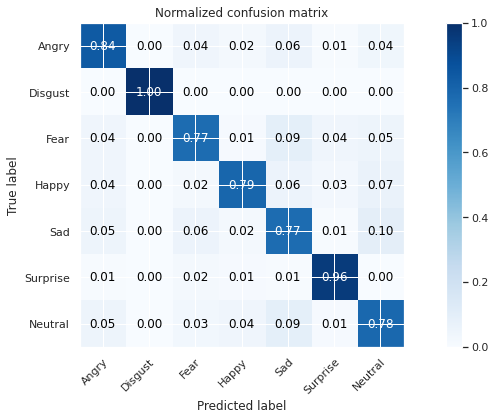

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

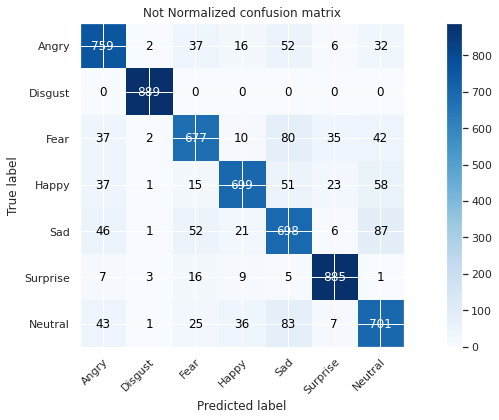

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=False, title='Not Normalized confusion matrix')
plt.show()

In [ ]:
print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != test_pred)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), test_pred))

total wrong validation predictions: 985


              precision    recall  f1-score   support

           0       0.82      0.84      0.83       904
           1       0.99      1.00      0.99       889
           2       0.82      0.77      0.79       883
           3       0.88      0.79      0.83       884
           4       0.72      0.77      0.74       911
           5       0.92      0.96      0.94       926
           6       0.76      0.78      0.77       896

    accuracy                           0.84      6293
   macro avg       0.84      0.84      0.84      6293
weighted avg       0.84      0.84      0.84      6293

